In [6]:
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap                          # for consistent variable importance 
import xgboost as xgb                # gradient boosting machines 
import xgboost
from sklearn.metrics import brier_score_loss

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix,precision_score,recall_score,classification_report, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour
import warnings

warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

import os

## **Deep Learning**

### Layer types:

Dense: Just your regular densely-connected NN layer

Dropout: Applies Dropout to the input

Batch normalisation: Layer that normalizes its inputs


In [7]:
df = pd.read_csv("../Sample Datasets/match_mania_data.csv")

df.head(10)

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000,7,0.137634,9.977419,2,1
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286,-13,-0.050691,0.293779,22,1
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500,1,-0.105847,-3.780242,11,1
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903,-15,0.260911,14.004744,30,1
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250,-5,-0.086174,0.866477,30,1
5,2016,137,3243,56,3203,51,9,8,0.600000,3.933333,0.812500,9.656250,1,-0.212500,-5.722917,5,1
6,2016,137,3257,87,3146,60,3,14,0.781250,12.718750,0.888889,9.111111,-11,-0.107639,3.607639,27,1
7,2016,137,3277,74,3125,60,4,13,0.750000,11.812500,0.733333,10.266667,-9,0.016667,1.545833,14,1
8,2016,137,3280,60,3151,50,5,12,0.787879,15.939394,0.774194,5.322581,-7,0.013685,10.616813,10,1
9,2016,137,3326,88,3138,69,3,14,0.774194,12.258065,0.606061,1.060606,-11,0.168133,11.197458,19,1


In [8]:
# Split data in X and y
X = df[["SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff']]
y = df[['WinA']]

In [9]:
X = df.drop(columns=['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB',
                    'WinA', 'ScoreDiff'])
y = df['WinA']

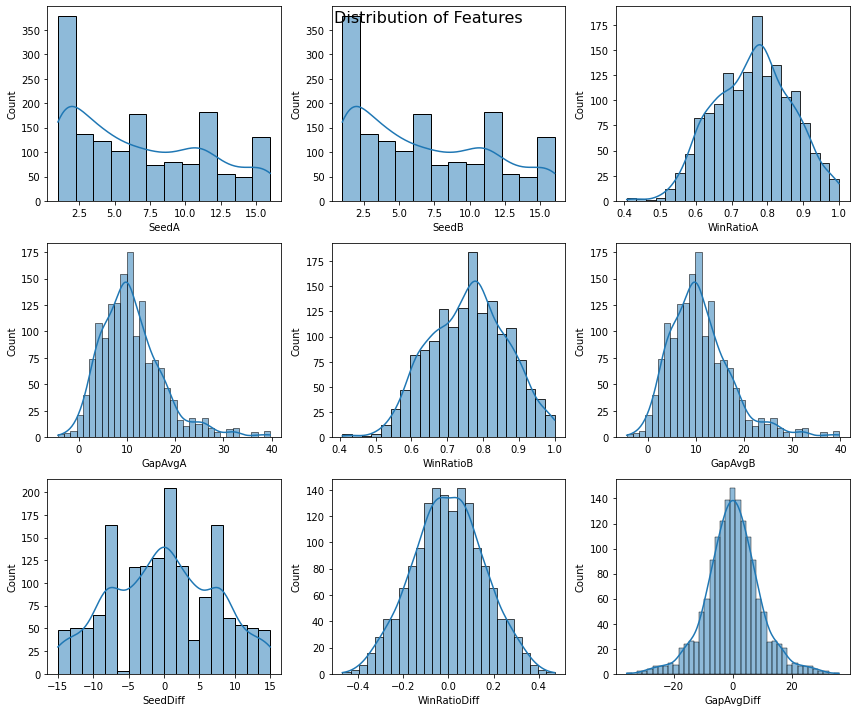

In [10]:
# create a figure with subplots for each feature
fig, axs = plt.subplots(3,3, figsize=(12, 10))

# plot the distribution of each feature
for i, col in enumerate(X.columns):
    sns.histplot(data=X, x=col, ax=axs[i//3, i%3], kde=True)
    
# add a title to the figure
fig.suptitle('Distribution of Features', fontsize=16)

# Adjust the layout of the subplots
fig.tight_layout()

# display the plot
plt.show()

In [11]:
X.shape

(1566, 9)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve#, plot_roc_curve

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define brier score loss which we will use as the loss function. The neural network will minimize this function.

In [13]:
def brier_score_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

The first neural network architecture that takes an input of shape (9,) and consists of multiple hidden layers with dropout regularization and batch normalization. Specifically, the neural network has three hidden layers, each with a dense layer, a batch normalization layer, and a dropout layer. The number of neurons in the dense layers are 128, 64, and 32 respectively. The dropout rate for each dropout layer is set to 0.3. The output layer has a single neuron with a sigmoid activation function. The model is compiled with the Adam optimizer and a custom loss function called "brier_score_loss".

Overall, this architecture has a total of 51,105 trainable parameters, which is relatively small. The use of batch normalization and dropout regularization may help prevent overfitting and improve the generalization performance of the model. The activation function and optimizer are also standard choices commonly used in neural networks

In [14]:
import tensorflow as tf

# Define the input shape
input_shape = (9,)

# Define the model architecture
# Create a neural network with dropout and multiple hidden layers
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=brier_score_loss)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [15]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
40/40 [==============================] - 7s 46ms/step - loss: 0.2355 - val_loss: 0.1992
Epoch 2/50
40/40 [==============================] - 0s 8ms/step - loss: 0.2140 - val_loss: 0.1964
Epoch 3/50
40/40 [==============================] - 0s 10ms/step - loss: 0.2012 - val_loss: 0.1940
Epoch 4/50
40/40 [==============================] - 0s 10ms/step - loss: 0.1979 - val_loss: 0.1910
Epoch 5/50
40/40 [==============================] - 0s 9ms/step - loss: 0.2080 - val_loss: 0.1923
Epoch 6/50
40/40 [==============================] - 0s 8ms/step - loss: 0.2043 - val_loss: 0.1909
Epoch 7/50
40/40 [==============================] - 0s 9ms/step - loss: 0.2004 - val_loss: 0.1906
Epoch 8/50
40/40 [==============================] - 0s 9ms/step - loss: 0.1890 - val_loss: 0.1906
Epoch 9/50
40/40 [==============================] - 1s 14ms/step - loss: 0.1912 - val_loss: 0.1921
Epoch 10/50
40/40 [==============================] - 0s 9ms/step - loss: 0.1921 - val_loss: 0.1892
Epoch 11/50
40/

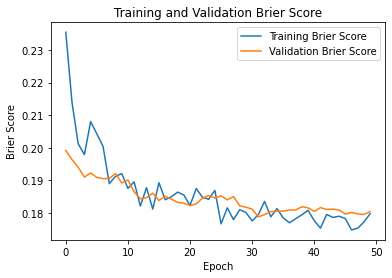

In [16]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.legend()
plt.show()

The second neural network architecture with an input shape of (9,) using the TensorFlow Keras API. The model consists of three fully connected hidden layers with 256, 128, and 64 neurons, respectively. Each hidden layer is followed by a batch normalization layer and a dropout layer. The dropout rates for the first and second dropout layers are 0.5, while the third dropout layer has a dropout rate of 0.3. Finally, the output layer is a single neuron with a sigmoid activation function.

Overall, this neural network has a total of 75,009 trainable parameters, which is larger than the previously described architecture. The use of dropout and batch normalization layers may help to reduce overfitting, while the choice of the ReLU activation function is a commonly used non-linear function in neural networks. The model is compiled with the Adam optimizer and a custom loss function called "brier_score_loss", meaning model is intended for binary classification tasks where the output of the model is interpreted as the probability of belonging to the positive class.

In [17]:
# Define the input shape
input_shape = (9,)

# Define the model architecture
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=brier_score_loss)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2560      
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0   

In [18]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
40/40 [==============================] - 12s 55ms/step - loss: 0.2299 - val_loss: 0.2063
Epoch 2/100
40/40 [==============================] - 1s 23ms/step - loss: 0.2164 - val_loss: 0.2111
Epoch 3/100
40/40 [==============================] - 1s 18ms/step - loss: 0.2152 - val_loss: 0.2107
Epoch 4/100
40/40 [==============================] - 1s 19ms/step - loss: 0.2058 - val_loss: 0.2013
Epoch 5/100
40/40 [==============================] - 1s 18ms/step - loss: 0.1963 - val_loss: 0.1945
Epoch 6/100
40/40 [==============================] - 1s 19ms/step - loss: 0.1985 - val_loss: 0.2019
Epoch 7/100
40/40 [==============================] - 1s 19ms/step - loss: 0.2026 - val_loss: 0.1952
Epoch 8/100
40/40 [==============================] - 1s 20ms/step - loss: 0.1949 - val_loss: 0.1961
Epoch 9/100
40/40 [==============================] - 1s 14ms/step - loss: 0.1997 - val_loss: 0.1934
Epoch 10/100
40/40 [==============================] - 0s 12ms/step - loss: 0.1955 - val_loss: 0.190

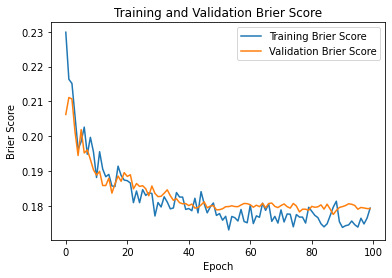

In [19]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.legend()
plt.show()

## **Neural Network Hyperparameter Tuning Bayesian Optimization**

We will now implement a Bayesian hyperparameter optimization search for a neural network model. The model architecture consists of three densely-connected layers with batch normalization and dropout regularization. The hyperparameters being optimized include the number of units in each layer, the learning rate of the optimizer, and the dropout rate of each dropout layer.

The code also defines a TensorBoard callback for monitoring the model training progress and uses early stopping to prevent overfitting. Finally, it prints the best hyperparameters found by the hyperparameter search.

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import TensorBoard

# Define the input shape
input_shape = (9,)

# Define the model architecture
def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_3', min_value=16, max_value=128, step=16), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model with the brier_score_loss and Adam optimizer
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=brier_score_loss,
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    return model

# Define the hyperparameter search space
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
    directory='my_dir',
    project_name='marchmadness_project')

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='logs')

# Train the model with the Keras tuner
tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3), tensorboard_callback])

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}")
print(f"The optimal number of units in the second densely-connected layer is {best_hps.get('units_2')}")
print(f"The optimal number of units in the third densely-connected layer is {best_hps.get('units_3')}")
print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}")
print(f"The optimal dropout rate for the first dropout layer is {best_hps.get('dropout_1')}")
print(f"The optimal dropout rate for the second dropout layer is {best_hps.get('dropout_2')}")
print(f"The optimal dropout rate for the third dropout layer is {best_hps.get('dropout_3')}")

ModuleNotFoundError: No module named 'kerastuner'

After running the code, TensorBoard logs can be visualized using the following command. This will open a web interface where you can view the loss and other metrics for each hyperparameter.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

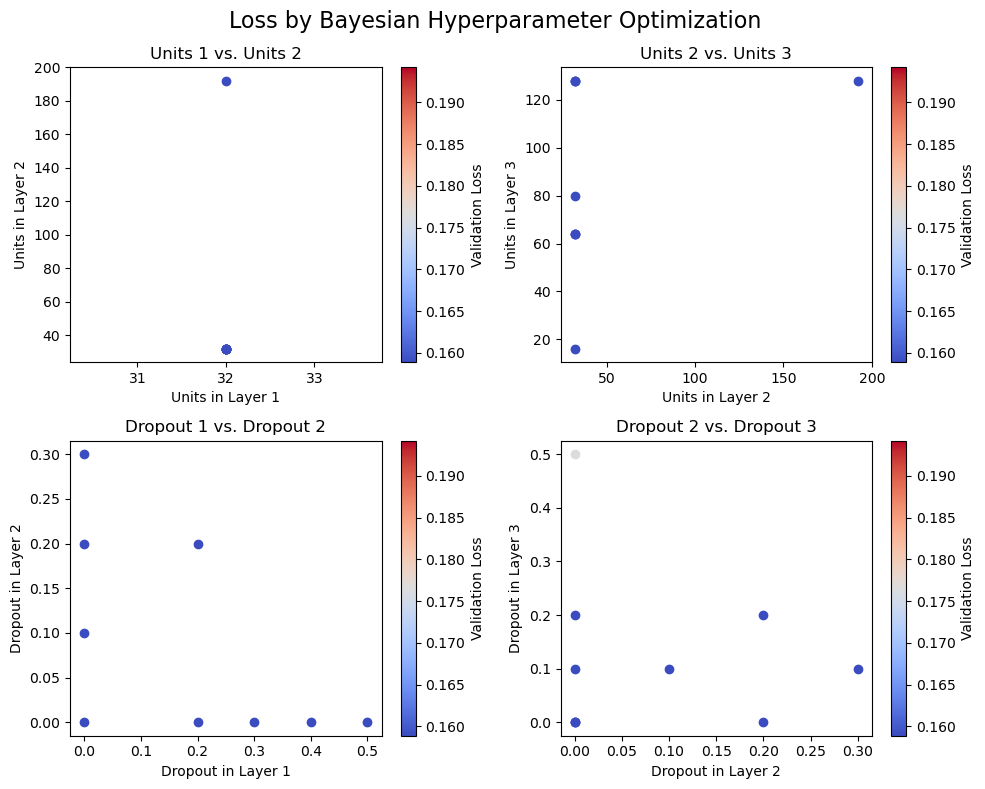

In [ ]:
# Retrieve the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=10)

# Create a figure with two rows and two columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Add main title
fig.suptitle("Loss by Bayesian Hyperparameter Optimization", fontsize=16)

# Plot the first graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[0, 0].scatter(hp["units_1"], hp["units_2"], c=val_loss, cmap="coolwarm")
axes[0, 0].set_xlabel("Units in Layer 1")
axes[0, 0].set_ylabel("Units in Layer 2")
axes[0, 0].set_title("Units 1 vs. Units 2")

# Plot the second graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[0, 1].scatter(hp["units_2"], hp["units_3"], c=val_loss, cmap="coolwarm")
axes[0, 1].set_xlabel("Units in Layer 2")
axes[0, 1].set_ylabel("Units in Layer 3")
axes[0, 1].set_title("Units 2 vs. Units 3")

# Plot the third graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[1, 0].scatter(hp["dropout_1"], hp["dropout_2"], c=val_loss, cmap="coolwarm")
axes[1, 0].set_xlabel("Dropout in Layer 1")
axes[1, 0].set_ylabel("Dropout in Layer 2")
axes[1, 0].set_title("Dropout 1 vs. Dropout 2")

# Plot the fourth graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[1, 1].scatter(hp["dropout_2"], hp["dropout_3"], c=val_loss, cmap="coolwarm")
axes[1, 1].set_xlabel("Dropout in Layer 2")
axes[1, 1].set_ylabel("Dropout in Layer 3")
axes[1, 1].set_title("Dropout 2 vs. Dropout 3")

# Add a colorbar to each graph
for ax in axes.flat:
    im = ax.collections[0]
    fig.colorbar(im, ax=ax, label="Validation Loss")

# Adjust the spacing between the graphs
fig.tight_layout()

# Display the figure
plt.show()

**Use best hyperparameters identified above.**

* The optimal number of units in the first densely-connected layer is **416**
* The optimal number of units in the second densely-connected layer is **192**
* The optimal number of units in the third densely-connected layer is **64**
* The optimal learning rate for the optimizer is **0.01**
* The optimal dropout rate for the first dropout layer is **0.0**
* The optimal dropout rate for the second dropout layer is **0.2**
* The optimal dropout rate for the third dropout layer is **0.5**

In [ ]:
# Define the input shape
input_shape = (9,)

# Define the model architecture using best hyperparameters
inputs = keras.Input(shape=input_shape)
x = layers.Dense(416, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(192, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the brier_score_loss and Adam optimizer
model.compile(optimizer='adam', loss=brier_score_loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_4 (Dense)             (None, 416)               4160      
                                                                 
 batch_normalization_3 (Batc  (None, 416)              1664      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 192)               80064     
                                                                 
 batch_normalization_4 (Batc  (None, 192)              768       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 192)               0   

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
40/40 [==============================] - 2s 12ms/step - loss: 0.2316 - accuracy: 0.6981 - precision_1: 0.6995 - recall_1: 0.7062 - auc_1: 0.7666 - val_loss: 0.2351 - val_accuracy: 0.7038 - val_precision_1: 0.7244 - val_recall_1: 0.6133 - val_auc_1: 0.7900
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2017 - accuracy: 0.7149 - precision_1: 0.7255 - recall_1: 0.7014 - auc_1: 0.7903 - val_loss: 0.2151 - val_accuracy: 0.7070 - val_precision_1: 0.6835 - val_recall_1: 0.7200 - val_auc_1: 0.8034
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.1979 - accuracy: 0.7101 - precision_1: 0.7116 - recall_1: 0.7172 - auc_1: 0.7931 - val_loss: 0.1993 - val_accuracy: 0.7229 - val_precision_1: 0.7114 - val_recall_1: 0.7067 - val_auc_1: 0.8062
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 0.1990 - accuracy: 0.7093 - precision_1: 0.7166 - recall_1: 0.7030 - auc_1: 0.7849 - val_loss: 0.2037 - val_accuracy: 0.7484 

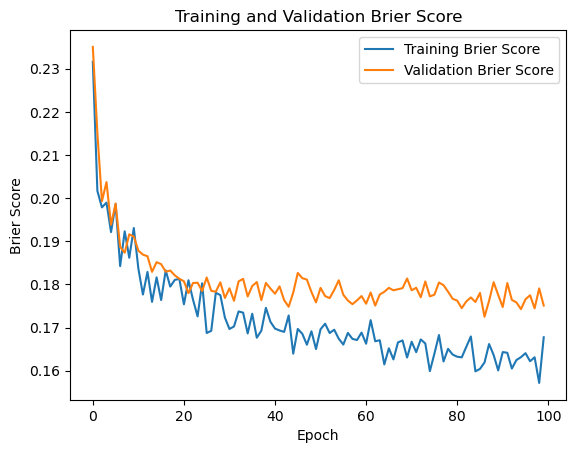

In [ ]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.legend()
plt.show()

## **Make Predictions**

In [ ]:
features = [
    "SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]

In [ ]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [ ]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            # Define the model inputs and outputs
            inputs = tf.keras.Input(shape=(df_train[features].shape[1],))
            outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(inputs)

            # Create the model
            model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

            # Compile the model with the custom loss function
            model.compile(optimizer='adam', loss=brier_score_loss)

        history = model.fit(df_train[features], df_train[target], validation_data=(df_val[features], df_val[target]), epochs=100, verbose=0)
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict(df_val[features])
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict(df_test[features])
                
            pred_tests.append(pred_test)
            
        if plot:
            # Prediction vs Score Diff scatter plot
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            # Prediction probability distribution plot
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability distribution')
            plt.show()
            # Training and Validation Brier Score plot
            plt.figure(figsize=(8, 5))
            plt.plot(history.history['loss'], label='Training Brier Score')
            plt.plot(history.history['val_loss'], label='Validation Brier Score')
            plt.title('Training and Validation Brier Score')
            plt.xlabel('Epoch')
            plt.ylabel('Brier Score')
            plt.legend()
            plt.show()
            # ROC curve
            fpr, tpr, thresholds = roc_curve(df_val['WinA'].values, pred)
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr)
            plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model (AUC = 0.5)')
            plt.title('ROC Curve')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.grid(True)
            # Add text for AUC score
            plt.text(0.6, 0.2, f'Model AUC = {auc_score:.2f}', fontsize=12)
            plt.legend()
            plt.show()
            
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests


Validating on season 2017
4084/4084 [==============================] - 4s 901us/step


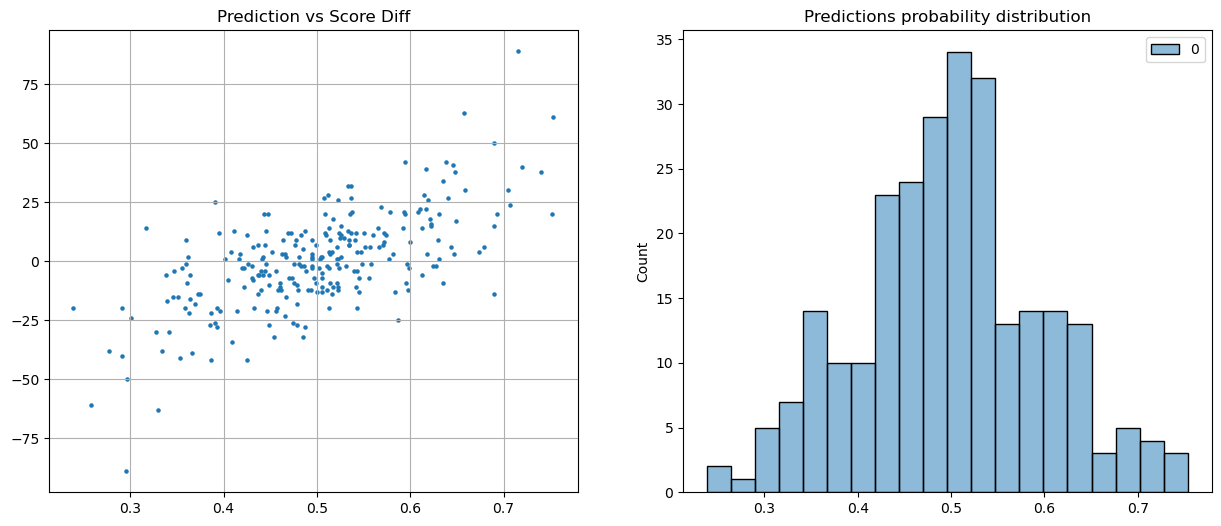

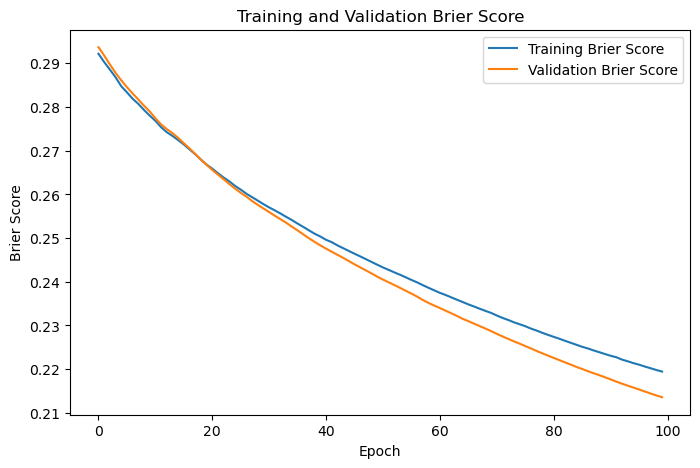

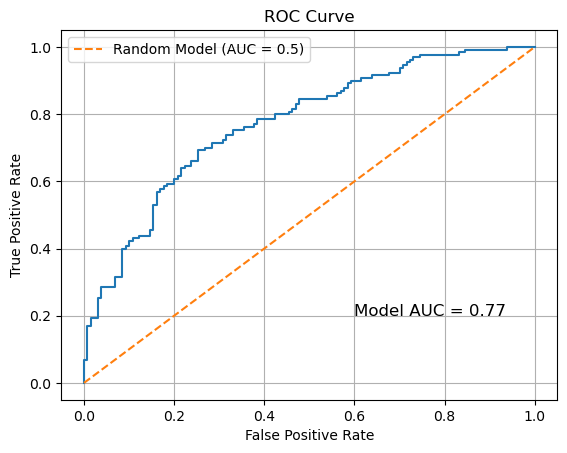

	 -> Scored 0.286

Validating on season 2018
4084/4084 [==============================] - 4s 891us/step


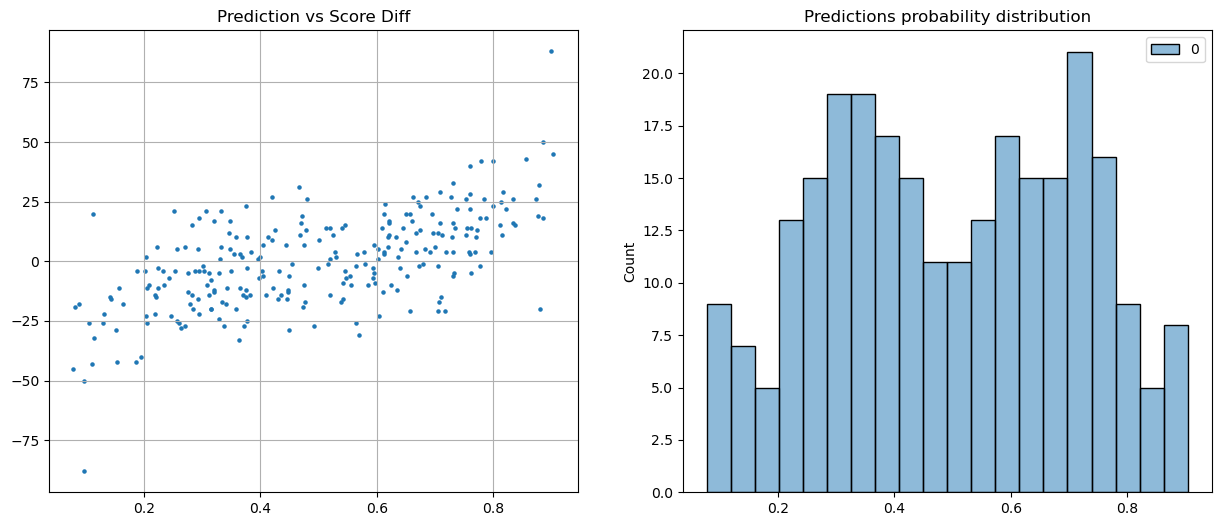

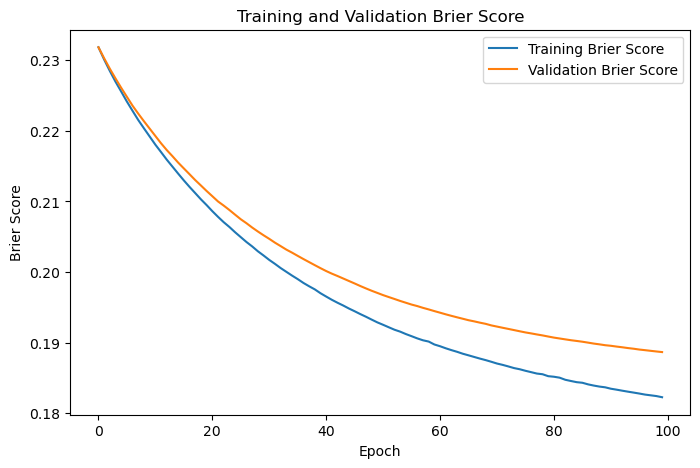

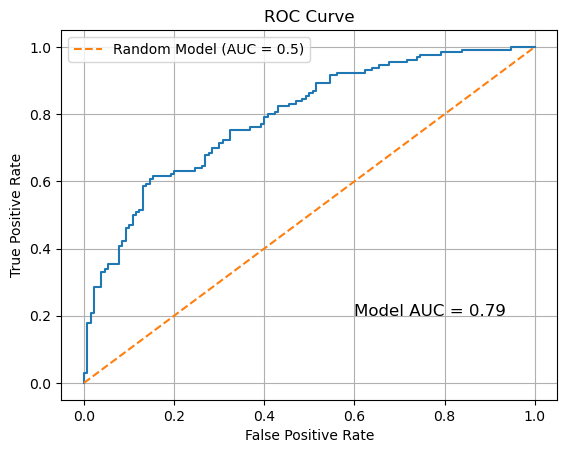

	 -> Scored 0.317

Validating on season 2019
4084/4084 [==============================] - 4s 881us/step


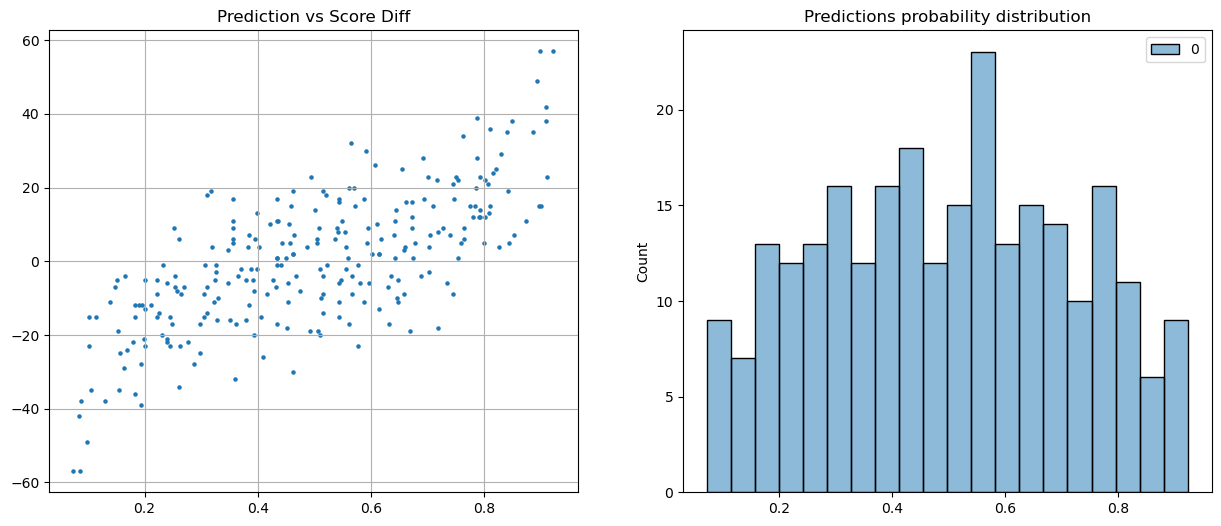

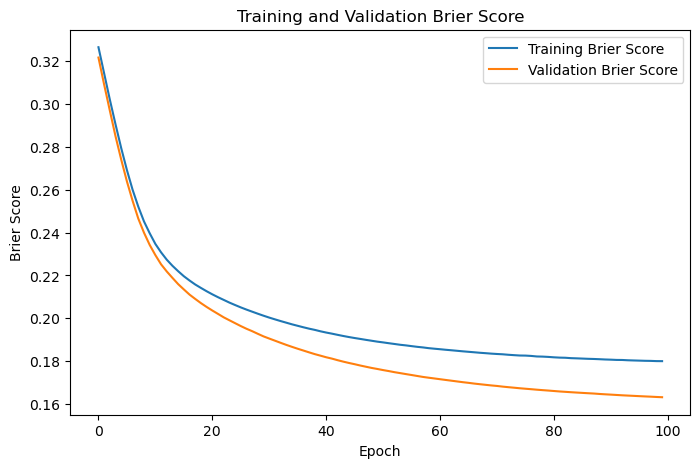

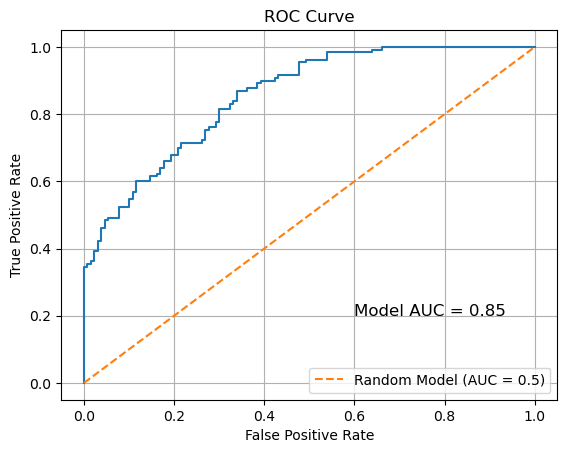

	 -> Scored 0.317

Validating on season 2021
4084/4084 [==============================] - 3s 815us/step


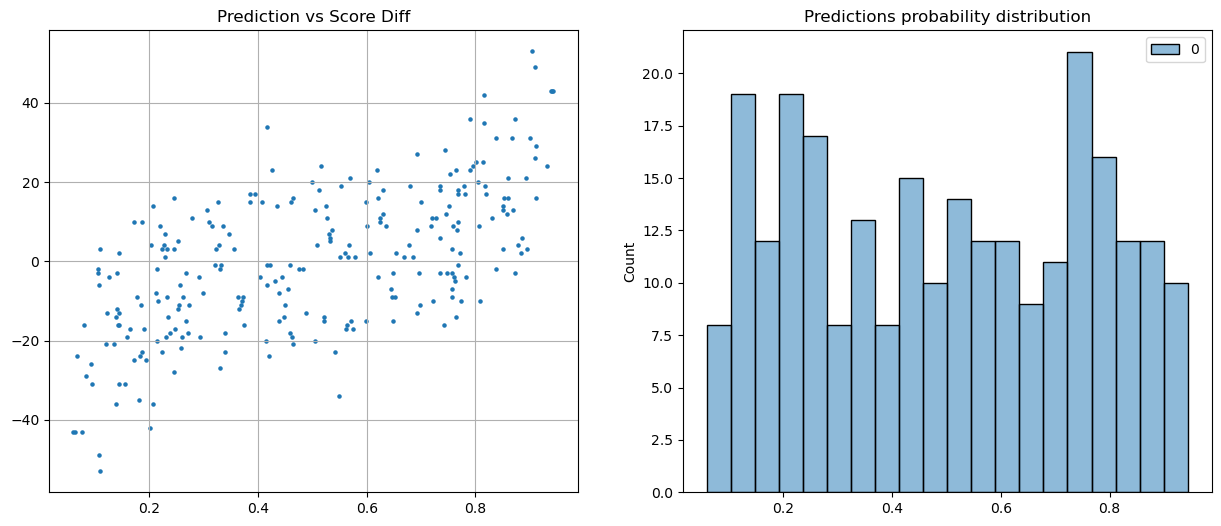

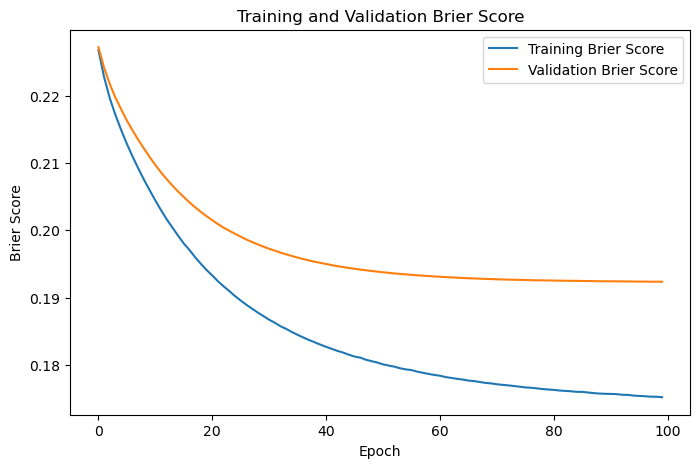

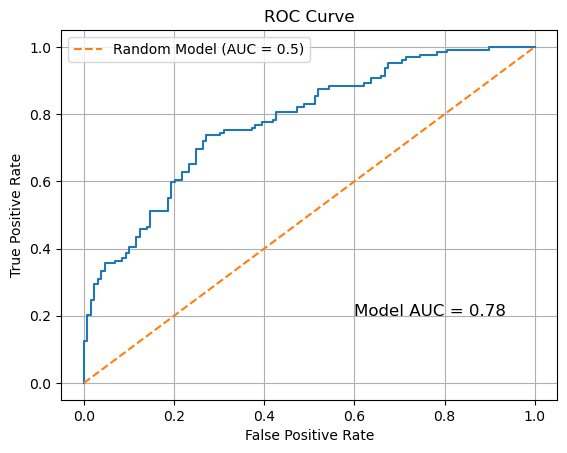

	 -> Scored 0.334

Validating on season 2022
4084/4084 [==============================] - 3s 834us/step


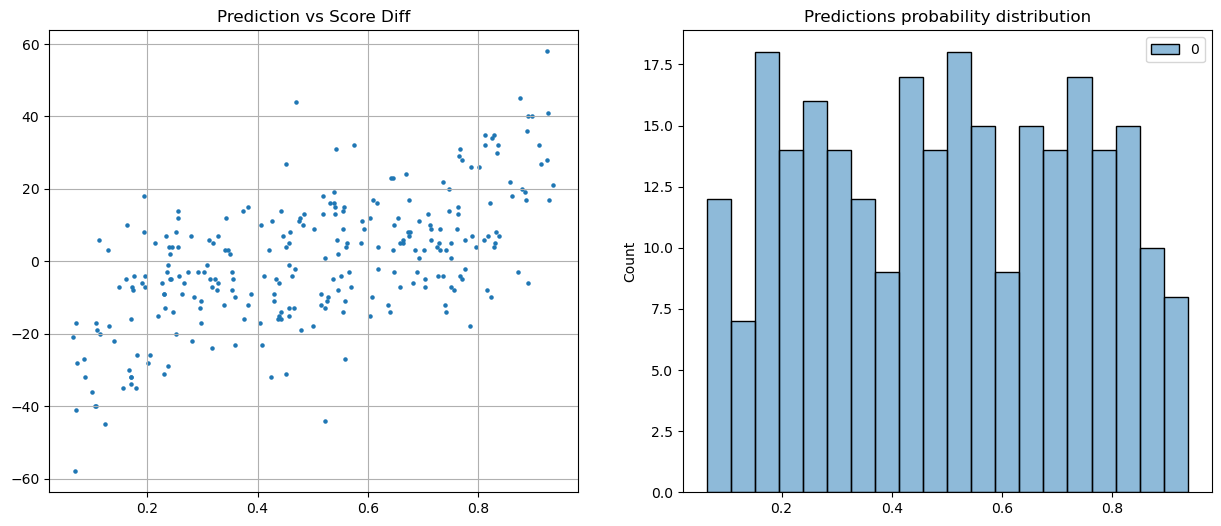

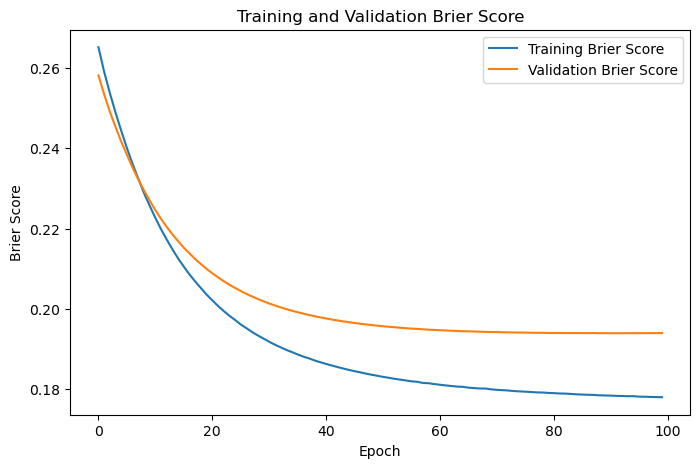

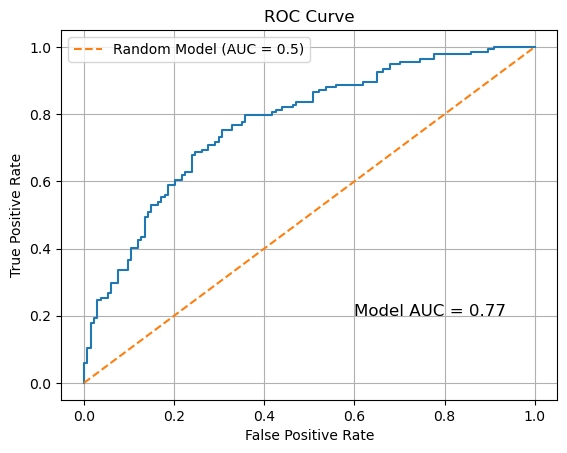

	 -> Scored 0.326

 Local CV is 0.316


In [ ]:
pred_tests = kfold(df, df_test, plot=True, verbose=1, mode="cls")

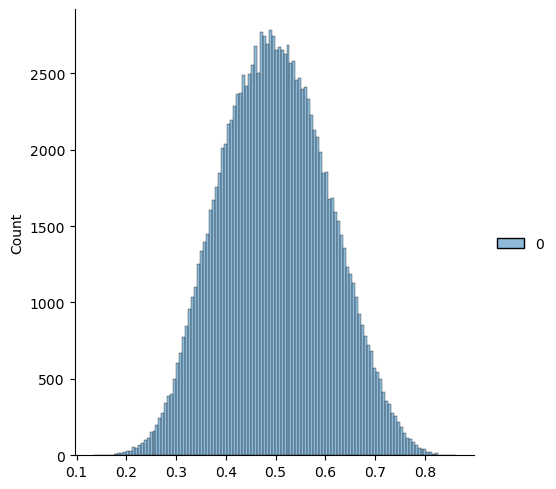

In [ ]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [ ]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [ ]:
final_sub.head(20)

,ID,pred
0,2023_1101_1102,0.468297
1,2023_1101_1103,0.407080
2,2023_1101_1104,0.330768
3,2023_1101_1105,0.512729
4,2023_1101_1106,0.558662
5,2023_1101_1107,0.579836
6,2023_1101_1108,0.456214
7,2023_1101_1110,0.449359
8,2023_1101_1111,0.477732
9,2023_1101_1112,0.337079
